# DS 542 Fall 2024 Notebook 9

The goal of this homework is to practice working with neural networks and modifying their architecture.

You will need to do the following with this notebook.
1. Load the MNIST test data into separate variables.
2. Modify the `MyNetwork` class to achieve at least a 98% training accuracy within 10 epochs. (This should be a pretty small change.)
2. Modify the `train_model` function to plot test loss and accuracy in addition to the training stats.
3. Fill in the implementation of the `MyThreeHiddenLayerNetwork` class to use a neural network with three hidden layers.


## Module Setup

In [30]:
!pip install livelossplot --quiet
!pip install torcheval --quiet

In [31]:
import livelossplot
import matplotlib.pyplot as plt
import torch
import torcheval.metrics
import torchvision

## GPU Setup

In [32]:
def to_gpu(t):
    if torch.cuda.is_available():
        return t.cuda()
    return t

def to_numpy(t):
    return t.detach().cpu().numpy()

device = to_gpu(torch.ones(1,1)).device
device

device(type='cuda', index=0)

## Load MNIST Data Set

In [33]:
torchvision.datasets.MNIST

torchvision.datasets.mnist.MNIST

In [34]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert the image to a tensor
    #torchvision.transforms.Normalize([0.0], [255.0]),
])

# Load the training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [35]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [36]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [37]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [38]:
train_dataset.targets.shape

torch.Size([60000])

In [ ]:
# Load and prepare test data.

# YOUR CHANGES HERE

### Data Loader for Batching

In [39]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000)

In [40]:
# shenanigans to get full batch of training data after running through the dataset transform.
# iterating train_dataset only gives one row at a time.
for (train_X, train_Y) in torch.utils.data.DataLoader(train_dataset, batch_size=100000):
    break
train_Y = to_gpu(train_Y)

### Visualize a Row

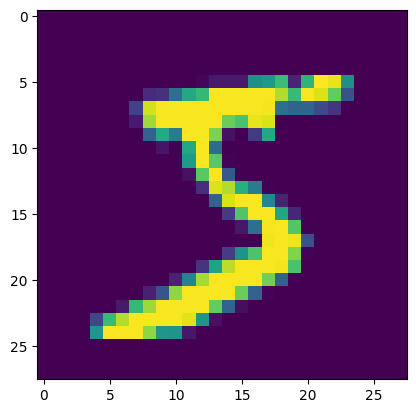

In [41]:
plt.imshow(train_dataset.data[0])

In [42]:
train_dataset.targets[0]

tensor(5)

## Configure Neural Network

In [61]:
# Modify this network so that it achieves 98% training accuracy within 10 epochs of training.

# YOUR CHANGES HERE

class MyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        hidden_width = 16

        self.fc_0 = torch.nn.Linear(28*28, hidden_width, device=device)
        self.fc_1 = torch.nn.Linear(hidden_width, 10, device=device)

        self.relu = torch.nn.ReLU()

    def forward(self, X):
        target_shape = X.shape[:1] + (28*28,)
        X = X.reshape(*target_shape)

        # first hidden layer
        X = self.fc_0(X)
        X = self.relu(X)

        # output layer is logits - no softmax
        X = self.fc_1(X)

        return X


This loss function will take in logits (softmax inputs) and target values (indices).
The PyTorch documentation says this will be more efficient than having the network output probabilities from softmax.

In [44]:
loss_function = torch.nn.CrossEntropyLoss()

## Training Loop

In [59]:
DEFAULT_EPOCHS = 1000 if torch.cuda.is_available() else 100

def train_model(model_class, epochs=DEFAULT_EPOCHS, learning_rate=1e-4, **kwargs):
    model = model_class(**kwargs)
    try:
        model = model.cuda()
    except:
        print("cuda() failed")
    model = torch.nn.DataParallel(model)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    liveloss = livelossplot.PlotLosses()
    for i in range(epochs):
        model.train()
        for (batch_X, batch_Y) in train_data_loader:

            optimizer.zero_grad(set_to_none=True)
            prediction = model(batch_X)
            loss = loss_function(prediction, to_gpu(batch_Y))
            loss.backward()
            optimizer.step()

        if (i + 1) % 2 == 0:
            # ADD TEST ACCURACY AND LOSS STATS TO CHARTS

            # YOUR CHANGES HERE
            with torch.no_grad():
                model.eval()
                prediction = model(train_X)
                loss = loss_function(prediction, train_Y)

            liveloss_updates = {
                'train_accuracy' : torcheval.metrics.functional.multiclass_accuracy(torch.argmax(prediction, dim=-1), train_Y),
                'train_loss': loss,
            }
            liveloss_updates = {k: to_numpy(v) for k, v in liveloss_updates.items()}
            liveloss.update(liveloss_updates,
                            current_step=i+1)
            liveloss.send()

    return model

In [ ]:
test_model = train_model(MyNetwork, epochs=10, learning_rate=0.001)

In [ ]:
sum(p.numel() for p in test_model.parameters())

In [51]:
# Make this class implement a neural network with three hidden layers.

# YOUR CHANGES HERE

class MyThreeHiddenLayerNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        hidden_width = 768

        self.fc_0 = torch.nn.Linear(28*28, hidden_width, device=device)
        self.fc_1 = torch.nn.Linear(hidden_width, 10, device=device)

        self.relu = torch.nn.ReLU()

    def forward(self, X):
        target_shape = X.shape[:1] + (28*28,)
        X = X.reshape(*target_shape)

        # first hidden layer
        X = self.fc_0(X)
        X = self.relu(X)

        # output layer is logits - no softmax
        X = self.fc_1(X)

        return X

In [ ]:
model_3 = train_model(MyThreeHiddenLayerNetwork, epochs=20, learning_rate=0.001)